In [684]:
import os
import shutil
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import librosa
import soundfile
import json
import textgrid
import pyroomacoustics as pra
from pyroomacoustics.directivities \
    import (CardioidFamily, DirectionVector, DirectivityPattern)
from pprint import pprint

In [685]:
"""Script parameters"""
target_amount_samples = 250
skipSamples = 0
target_dir = '/workspace/training/KEC'


"Persons"
speakers_in_room = 5

"ROOM"
# size of the Listeners head diameter
head_size = 0.2

randomize_room = False
# room generation will be laplace distributed in these intervalls [width, length, height]
normal_room_dim = [15, 20, 4]
room_dim_ranges = [[3, 30], [3, 30], [2.5, 5]]

# The amout Walls absorb Sound
normal_absorption = 1.2
absorption_range = [1, 2]

# the time it take until the signal drops by 60 dB
normal_rt60 = 0.25
rt60_range = [0.05, 0.75]

"AUdio"
sampleRate = 16000
#total_length = 30
max_audio_length = 30
#min_audio_length = 5
min_characters_per_sentence = 20


# 'nice to have' for data generation
source_dataset = 'KEC - https://clarin.phonetik.uni-muenchen.de/BASRepository/index.php?target=Public/Corpora/KEC/KEC.1.php'


In [686]:
"""Visualization"""


def scatterplot3d(points, dims):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(0, dims[0])
    ax.set_ylim(0, dims[1])
    ax.set_zlim(0, dims[2])
    c = listenerSpeakerColors(len(points))

    i = 0
    for p in points:
        ax.scatter(p[0], p[1], p[2], color=c[i])
        i = i+1


def scatterplot2d(points, middle, directivities, dims):
    print(points)
    plot2dPoints(points)
    plt.scatter(middle[0], middle[1], c='#5f59')
    if dims != None:
        plt.xlim(0, dims[0])
        plt.ylim(0, dims[1])


def plotDirectivities(base, middle, baseRefDirs, pos, posDirs, roomCorners):
    def sub(x, y):
        return [x[0]-y[0], x[1]-y[1]]

    arrowLen = 5
    plt.xlim(-room_dim_ranges[0][1], room_dim_ranges[0][1])
    plt.ylim(-room_dim_ranges[1][1], room_dim_ranges[1][1])

    pprint(roomCorners)
    a = roomCorners[0]
    b = roomCorners[1]
    c = roomCorners[3]
    d = roomCorners[2]

    plt.arrow(a[0], a[1], sub(b, a)[0], sub(b, a)[1], color='#000')
    plt.arrow(b[0], b[1], sub(c, b)[0], sub(c, b)[1], color='#000')
    plt.arrow(c[0], c[1], sub(d, c)[0], sub(d, c)[1], color='#000')
    plt.arrow(d[0], d[1], sub(a, d)[0], sub(a, d)[1], color='#000')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.scatter(base[0], base[1], c='#55f9')
    plt.scatter(middle[0], middle[1], c='#5f59')

    v = toVektor(baseRefDirs[0][0], arrowLen)
    plt.arrow(base[0], base[1], v[0], v[1], color='#55f9')
    v = toVektor(baseRefDirs[1][0], arrowLen)
    plt.arrow(base[0], base[1], v[0], v[1], color='#5F59')

    for i in range(len(posDirs)):
        v = toVektor(posDirs[i][0], arrowLen)
        plt.arrow(base[0], base[1], v[0], v[1], color='#f559')
        plt.scatter(pos[i][0], pos[i][1], c='#f559')


def plot2dPoints(points):
    x = [points[i][0] for i in range(len(points))]
    y = [points[i][1] for i in range(len(points))]
    c = listenerSpeakerColors(len(points))
    plt.scatter(x, y, c=c)


def listenerSpeakerColors(count: int):
    if count < 1:
        return []
    if count == 1:
        return ['#55F9']
    colors = ['#55F9', '#55F9']
    for i in range(2, count):
        colors.append('#F559')
    return colors


def rotationMatrix(angle):
    return np.array([[math.cos(angle), -math.sin(angle)],
                     [math.sin(angle), math.cos(angle)]],)


def rotateAroundPoint(v, base, angle):
    x = np.subtract(v, base)
    x = list(np.dot(rotationMatrix(angle), x[:2]))
    x.append(v[2])
    x = np.add(x, base)
    return x


def customPlot(positions, middle, dirs, baseAngle, roomDims):
    plt.clf()
    plt.subplot(121)

    positions = positions.copy()
    dirs = dirs.copy()
    roomDims = roomDims.copy()
    a = [0, 0, 0]
    b = [roomDims[0], 0, 0]
    c = [0, roomDims[1], 0]
    d = [roomDims[0], roomDims[1], 0]
    roomCorners = [a, b, c, d]
    # replace right ear  direction with facing forward direction
    dirs[1] = [baseAngle, math.pi/2]

    plotDirectivities(positions[0], middle, dirs[:2],
                      positions[2:], dirs[2:], roomCorners)

    plt.show()
    plt.subplot(122)
    positions = [rotateAroundPoint(v, positions[0], -baseAngle) for v in positions]
    roomCorners = [rotateAroundPoint(v, positions[0], -baseAngle)
                   for v in roomCorners]
    dirs = [[d[0]-baseAngle, d[1]] for d in dirs]
    plotDirectivities(positions[0], middle, dirs[:2],
                      positions[2:], dirs[2:], roomCorners)

    plt.show()


In [687]:
"""Util"""
def rec_filter(x):
    return True if 'rec' in x else False


def wav_filter(x):
    return True if '.wav' in x else False


def txt_filter(x):
    return True if '.TextGrid' in x else False


def as_filter(x):
    return True if 'AS' in x else False


def idx_filter_txt(x, y):
    return True if x[len(x) - 10] == y else False


def rec_filter(x):
    return True if 'rec' in x else False


def norm2(x):
    n = np.sum(list(map(lambda y: y**2, x)))
    return n


def distance(x, y):
    v = [ x[i]-y[i] for i in range(len(x))]
    return norm2(v)


def avg(x):
    return sum(x)/len(x)

def toVektor(angle, len):
    return [np.round(len*math.cos(angle),15), np.round(len*math.sin(angle),15)]

"""Anlges"""
# von a nach b in deg
def toAngle(a, b):

    deltaY = b[1] - a[1]
    deltaX = b[0] - a[0]
    return math.atan2(deltaY, deltaX)

In [688]:
"Dataset specific Wav Generation"
def FileGeneratorsKEC():
    src = '/workspace/data/KEC'
    recFolders = list(filter(lambda f: rec_filter(f), os.listdir(src)))
    allWavfiles = []
    alltxtFiles = []
    for rec in recFolders:
        currentDir = src+"/"+rec

        wavFilesOfFolder = list(
            filter(lambda f: wav_filter(f), os.listdir(currentDir)))
        wavFilesOfFolder = list(
            map(lambda f: currentDir+"/"+f, wavFilesOfFolder))
        allWavfiles.extend(wavFilesOfFolder)

        txtFilesOfFolder = list(
            filter(lambda f: txt_filter(f), os.listdir(currentDir)))
        txtFilesOfFolder = list(
            map(lambda f: currentDir+"/"+f, txtFilesOfFolder))
        alltxtFiles.extend(txtFilesOfFolder)

    def wavGen():
        for file in allWavfiles:
            yield file

    def textGen():
        for file in alltxtFiles:
            yield file

    return wavGen, textGen

# splits text file in parts


def split_sentence(textGrid):
    currentTime = 0
    sentence_start = 0
    sentences, timestamp = [], []
    sentence = ''

    for t in textGrid[0]:
        if currentTime > t.maxTime:
            break

        currentTime = t.maxTime
        if sentence == '':
            sentence_start = t.maxTime

        sentence += ' ' + t.mark
        duration = np.round(t.maxTime - sentence_start, 5)

        if '<P>' in t.mark:
            if duration < max_audio_length and duration >= 5 and len(sentence) > min_characters_per_sentence:
                sentences.append(sentence[:-3].strip())
                timestamp.append([sentence_start, t.maxTime, duration])
            sentence = ''

    return sentences, timestamp


def VoiceLineGeneratorKEC(count, voicesPerSample):
    wavGen, textGen = FileGeneratorsKEC()
    allWavPaths = [p for p in wavGen()]
    allTxtPaths = [p for p in textGen()]

    for i in range(count):
        w = []
        t = []
        for j in range(voicesPerSample):

            random_file = np.random.randint(0, len(allWavPaths))
            sentences, timestamps = split_sentence(
                textgrid.TextGrid.fromFile(allTxtPaths[random_file]))
            random_phrase = np.random.randint(0, len(timestamps))
            ts = timestamps[random_phrase]
            t.append(ts)
            w.append(loadWavFile(allWavPaths[random_file], ts[0], ts[2]))

        yield w, t
    return


In [689]:
"""Room Functions"""


def generate_room_characteristics():
    dims = rt60 = absorption = 0
    if randomize_room:
        dims: list(int) = [np.random.randint(room_dim_ranges[i, 0], room_dim_ranges[i, 1])
                           for i in range(len(room_dim_ranges[:]))]

        rt60: float = rt60_range[0] + \
            (rt60_range[1]-rt60_range[0])*np.random.random()

        absorption: float = absorption_range[0] + \
            (absorption_range[1]-absorption_range[0]) * np.random.random()

    else:
        dims = normal_room_dim
        rt60 = normal_rt60
        absorption = normal_absorption

    return dims, rt60, absorption


def random_position_in_room(roomDims):
    x = np.random.random() * (roomDims[0]-1) + 0.5
    y = np.random.random() * (roomDims[1]-1) + 0.5
    z = 1.73
    return [x, y, z]


def positions_too_close(positions):
    for a in positions[1:]:
        for b in positions[1:]:
            if a == b:
                continue
            if distance(a, b) < 1:
                return True
    return False


def transform_to_directivities(positions, roomDims):
    dirs = []
    middle = [avg(np.transpose(positions)[i])
              for i in range(len(positions[0]))]

    listenerPos = positions[0]
    # Winkel aus Vogelperspeltive, in die Listnener guckt
    baseAngle = toAngle(listenerPos[:2], middle[:2])

    # linkes und rechtes ohr des LIsteners
    dirs.append([(baseAngle + math.pi/2), math.pi/2])  # left?
    dirs.append([(baseAngle - math.pi/2), math.pi/2])  # right?

    for pos in positions[2:]:
        dirs.append([toAngle(listenerPos, pos), math.pi/2])

    return dirs, baseAngle, middle


def random_persons_in_room(roomDims, count):
    def pos_in_room(count):
        pos = []
        for i in range(count):
            pos.append(random_position_in_room(roomDims))
        return pos

    # do while: erzeuge solange bis gültiges ergebnis
    positions = pos_in_room(count)
    while(positions_too_close(positions)):
        positions = pos_in_room(count)
    positions[0] = positions[1]
    dirs, baseAngle, middle = transform_to_directivities(positions, roomDims)

    customPlot(positions, middle, dirs, baseAngle, roomDims)

    return positions, dirs

# calculates mic positions depentend of middle point


def get_pos_mics(position, dir):

    x = point_pos(position[0], head_size/2, dir[0][0])
    y = point_pos(position[0], head_size/2, dir[1][0])

    return [x, y]

# calculates mic position depentend of middle point


def point_pos(x, d, theta):
    theta_rad = math.pi/2 - theta
    return [x[0] + d * math.cos(theta_rad), x[1] + d*math.sin(theta_rad), x[2]]


In [690]:
"""WAV and audio Mixing"""
def loadWavFile(path, offset=0, duration=None):
    wav, sr = librosa.load(path, sr=sampleRate, offset=offset,
                           duration=duration, mono=True)

    wav = librosa.util.normalize(wav)
    return wav


def makeCardioid(direction):
    return CardioidFamily(
        orientation=DirectionVector(
            azimuth=direction[0], colatitude=direction[1], degrees=True),
        pattern_enum=DirectivityPattern.CARDIOID,
    )


def createRoom(room_dim, rt60,absorption):
    e_absortion, max_order = pra.inverse_sabine(rt60, room_dim)
    room: pra.ShoeBox = pra.ShoeBox(room_dim, fs=sampleRate, materials=pra.Material(
        e_absortion), absorption=absorption, max_order=max_order)
    return room

def mixRoom(room,listenerPositions, listenerDirs, speakerPositions, speakerDirs, wavs):
    listenerDirs = list(map(lambda d: makeCardioid(d), listenerDirs))
    speakerDirs = list(map(lambda d: makeCardioid(d), speakerDirs))

    mic_array = pra.MicrophoneArray(
        np.c_[listenerPositions[0], listenerPositions[1]], directivity=listenerDirs, fs=sampleRate)

    for i in range(len(speakerPositions)):
        room.add_source(
            position=speakerPositions[i], directivity=speakerDirs[i], signal=wavs[i])
    room.add_microphone_array(mic_array)

    return room

def exportRoom(room:pra.ShoeBox, filepath):
    room.mic_array.to_wav(filepath, norm=True, bitdepth=np.float32)
    

In [691]:
"""Exporting training data"""

# sampleNr: int, speakerIdsList:int[n], positionList:float[n+2], directions:float[n+2], timeframes:floats[n][2]
def createJsonData(sampleNr, speakerIdsList, positionList, directions, timeframes):
    speakers = []
    for i in range(len(speakerIdsList)):
        speaker = {
            'id': speakerIdsList[i],
            'position': positionList[i+2],
            'direction': directions[i+2],
            'startTime': timeframes[i][ 0],
            'endTime': timeframes[i][ 1],
            'duration': timeframes[i][ 2]
        }
        speakers.append(speaker)

    return {
        'comment': 'direction: [azimuth, colatitude]',
        'sample': {
            'id': sampleNr,
            'speakers': speakers,
            'listener': {
                'position': positionList[0],
                'directionLeft': directions[0],
                'directionRight': directions[1]
            },
            'source': source_dataset
        }
    }

def createFolder(targetFolder):
    try:
        os.mkdir(targetFolder)
    except Exception as e:
        shutil.rmtree(targetFolder)
        os.mkdir(targetFolder)

def exportSample(sampleNr,room,wavs,json_data):
    folder = target_dir+'/'+str(sampleNr)
    createFolder(folder)
    exportRoom(room, folder+'/room.wav')
    for i in range(len(wavs)):
        soundfile.write(folder+f'/speaker{i}.wav', wavs[i], sampleRate)
    with open(folder+'/description.json', 'w') as file:
        json.dump(json_data, file, indent=4)

[[0, 0, 0], [15, 0, 0], [0, 20, 0], [15, 20, 0]]


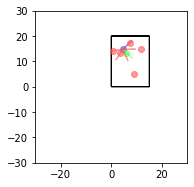

[array([11.36140431,  0.87503069,  3.46      ]),
 array([22.26103928, 11.18027002,  3.46      ]),
 array([-2.37891479, 15.40787731,  3.46      ]),
 array([ 8.52072017, 25.71311664,  3.46      ])]


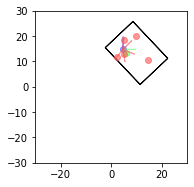

Generated Room Nr.1.


In [692]:
"""MAIN"""

def generate():
    sampleNr = skipSamples
    gen = VoiceLineGeneratorKEC(1, speakers_in_room)
    for (wavs, timestamps) in gen:
        #creating parameters
        sampleNr += 1
        dims, rt60, absorption = generate_room_characteristics()
        room = createRoom(dims, rt60, absorption)
        pos, dirs = random_persons_in_room(dims, speakers_in_room+2)
        listener_pos = get_pos_mics(pos[:2], dirs[:2])
        #creating data
        room = mixRoom(room, listener_pos, dirs[:2], pos[2:], dirs[2:], wavs)
        room.simulate()
        json_data = createJsonData(sampleNr, range(
            len(wavs)), pos, dirs, timestamps)

        exportSample(sampleNr,room,wavs,json_data)

        msg = f'Generated Room Nr.{sampleNr}.'
        print(msg)


if __name__ == '__main__':
    generate()


In [693]:

#       0,      pi,     pi/2,   -pi/2 ,  pi/4,  ,3/4 pi    -pi/4    -3/4 pi
vs = [[1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [-1, 1], [1, -1], [-1, -1]]
angs = []
for v in vs:
    angs.append(toAngle([0,0], v))

vs2 = []
for ang in angs:
    vs2.append(toVektor(ang,1))

res = []

for i in range(len(vs)):
    res.append([vs[i],angs[i],vs2[i]])

pprint(res)


[[[1, 0], 0.0, [1.0, 0.0]],
 [[-1, 0], 3.141592653589793, [-1.0, 0.0]],
 [[0, 1], 1.5707963267948966, [0.0, 1.0]],
 [[0, -1], -1.5707963267948966, [0.0, -1.0]],
 [[1, 1], 0.7853981633974483, [0.707106781186548, 0.707106781186548]],
 [[-1, 1], 2.356194490192345, [-0.707106781186548, 0.707106781186548]],
 [[1, -1], -0.7853981633974483, [0.707106781186548, -0.707106781186548]],
 [[-1, -1], -2.356194490192345, [-0.707106781186548, -0.707106781186548]]]
